Models the generation of a keypoint heatmap image as a multi-stage generative model:

1) A set of object-frame keypoints $p_O$ is transformed into camera frame according to $p_C = RSp + T$, for $R$ ~ uniform over $SO(3)$ (implemented as random normal 4-vectors normalized into quaternions), $S = diag(s)$ with each of the 3 elements of $s$ from Inverse gamma distributions, and $T$ drawn fron a diagonal normal.

2) Camera-frame keypoints $p_C$ are projected into the (2D) image plane via a perspective projection $p_{Im} = K(\hat{p})$.

3) An image is formed by summing a narrow-width Gaussian at each pixel keypoint location and saturating at 1; at pixel $(u, v)$, $z(u, v) = min(\sum_i{\mathcal{N}(\mu = p_{Im}, \sigma=\Sigma_{pt})}, 0)$.

4) The observed keypoint image is generated by pixelwise Normal draws: $z_{obs}(u, v) = \mathcal{N}(\mu = z(u, v), \sigma=\Sigma_{obs})$.


So the only random choices being made are the pose and size of the box; so I'll try posterior inference of $p(R, T, s | z_{obs})$ with MCMC.

In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from scene_generation.utils.torch_quaternion import quat2mat

import operator
from functools import reduce  # Required in Python 3
def prod(iterable):
    return reduce(operator.mul, iterable, 1)

torch.set_default_tensor_type(torch.FloatTensor)

            Trace Shapes:          
             Param Sites:          
         dimensions_alpha   3      
          dimensions_beta   3      
            Sample Sites:          
               batch dist   |      
                    value 1 |      
            box_quat dist 1 |  4   
                    value 1 |  4   
             box_xyz dist 1 |  3   
                    value 1 |  3   
      box_dimensions dist 1 |  3   
                    value 1 |  3   
box_keypoint_heatmap dist 1 | 32 32
                    value 1 | 32 32
Total Log prob:  tensor(955.3184, grad_fn=<AddBackward0>)
R:  tensor([[ 0.1725, -0.8257,  0.5371],
        [ 0.4676, -0.4113, -0.7824],
        [ 0.8669,  0.3861,  0.3152]])
T:  tensor([[0.0234, 0.0230, 0.8877]])
S:  tensor([[0.4213, 0.3003, 0.4198]], grad_fn=<PowBackward1>)


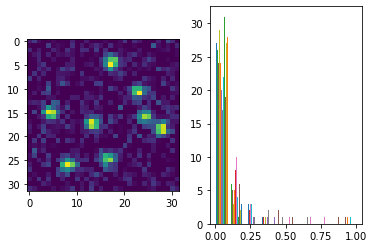

In [2]:
class Box():
    def __init__(self, name, R, t, s):
        # Pose quatxyz in camera frame
        # Dimensions x y z
        assert R.shape[-2:] == (3, 3), pose.shape
        assert s.shape[-1] == 3, s.shape
        assert R.shape[:-2] == t.shape[:-1] and R.shape[:-2] == s.shape[:-1], "Unaligned batch shapes."
        self.batch_shape = tuple(R.shape[:-2])
        self.N_keypoints = 8
        self.name = name
        self.R = R
        self.t = t
        self.s = s

    def generate_keypoints(self):
        # Renders corner keypoints under this box's transformation.
        # Stack pose elements into TF matrix 
        N = prod(self.batch_shape)
        R_flattened = self.R.reshape(N, 3, 3)
        t_flattened = self.t.reshape(N, 3)
        Rt = torch.cat([R_flattened, t_flattened.unsqueeze(-1)], dim=2) # [N,3,4]
        # Make homogenous
        hom_aug = torch.cat([torch.zeros([N, 1, 3]),
                             torch.ones([N, 1, 1])],
                            dim=2).to(Rt.device)
        tf = torch.cat([Rt, hom_aug], dim=1) # [N,4,4]

        pts = torch.tensor(
            np.array([[-1., -1., -1., -1, 1., 1., 1., 1.],
                      [-1., -1., 1., 1., -1., -1., 1., 1.],
                      [-1., 1., -1., 1., -1., 1., -1., 1.]]),
            dtype=self.R.dtype)
        pts = pts.unsqueeze(0).repeat(N, 1, 1)
        pts = pts * self.s.reshape(N, 3, 1).repeat(1, 1, self.N_keypoints) / 2. # [N, 3]
        pts_homog = torch.cat([pts, torch.ones(N, 1, pts.shape[2])], dim=1)
        pts = torch.bmm(tf, pts_homog)[..., :3, :]
        return pts.reshape(self.batch_shape + (3, self.N_keypoints))

    def sample_keypoint_images(self, image_shape, camera_K, temperature=1.0):
        # Project keypoints into UV coordinates, create a "target" image by
        # summing normal distributions at each keypoint location, and
        # sample an observed image.
        assert(camera_K.shape == (3, 3))
        sigma_keypoint = 1.
        sigma_observation = 0.1
        
        N = prod(self.batch_shape)

        # Calculate 3D keypoint locations in camera frame.
        pts = self.generate_keypoints().reshape(N, 3, self.N_keypoints)
        # Project each point into the image plane.
        pts_uv_unnormalized = torch.bmm(camera_K.repeat(N, 1, 1), pts).permute(0, 2, 1) # [N, N_keypoints, 3]
        pts_uv = torch.empty(N, self.N_keypoints, 2)
        pts_uv[..., 0] = pts_uv_unnormalized[..., 0] / pts_uv_unnormalized[..., 2]
        pts_uv[..., 1] = pts_uv_unnormalized[..., 1] / pts_uv_unnormalized[..., 2]
        
        grid_x, grid_y = torch.meshgrid(
            torch.arange(image_shape[0]),
            torch.arange(image_shape[1])
        )
        batched_grid = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1).reshape(1, -1, 2)
        batched_grid = batched_grid.repeat(N, 1, 1)
        
        # Collect output images across the different points.
        peak_heatmaps = [] # (self.batch_size, image_shape[0], image_shape[1]))
        for k in range(self.N_keypoints): # probably could batch this too...
            # Distances to the peak, for each pixel in the image
            # (Repeats pts to be the same size as the flattened batched grid so the
            # batching works out)
            distances_from_peak = torch.sum(
                    (batched_grid - pts_uv[..., k, :].unsqueeze(1).repeat(1, batched_grid.shape[1], 1))**2.,
                axis=-1)
            peak_heatmap = torch.exp(-distances_from_peak / (2. * (sigma_keypoint ** 2.))) + 1E-6 # Avoid numerical issue when normalizing
            peak_heatmap = peak_heatmap.reshape(-1, image_shape[0], image_shape[1])
            peak_heatmaps.append(peak_heatmap)
        
        # Sum up the heatmaps and clamp at one.
        total_heatmap_vals = torch.clamp(torch.stack(peak_heatmaps, axis=-1).sum(axis=-1), 0., 1.)
        heatmap_images = total_heatmap_vals.reshape(self.batch_shape + tuple(image_shape))
        
        # Finally, we can use those to sample a keypoint
        # occurance image.
        with pyro.poutine.scale(scale=1./temperature):
            keypoint_occurance_image = pyro.sample(
                self.name + "_keypoint_heatmap",
                dist.Normal(heatmap_images,
                            sigma_observation).to_event(2))
        return keypoint_occurance_image


    @staticmethod
    def sample(name = "box", batch_size=1):
        with pyro.plate("batch", batch_size):
            quat = pyro.sample(
                name + "_quat",
                dist.Uniform(torch.ones(4)*-1.01,
                             torch.ones(4)*1.01).to_event(1)
            )
            if len(quat.shape) == 1:
                quat = quat.reshape(-1, 4)
            quat = F.normalize(quat, p=2, dim=-1)
            R = quat2mat(quat)

            xyz_mean = torch.zeros(3)
            xyz_mean[2] = 1.
            xyz_scale = torch.ones(3) * 0.1
            xyz = pyro.sample(
                name + "_xyz",
                dist.Normal(xyz_mean, xyz_scale).to_event(1)
            )
            if len(xyz.shape) == 1:
                xyz = xyz.reshape(-1, 3)

            dimensions_alpha = pyro.param(
                "dimensions_alpha", torch.ones(3) * 3.,
                constraint=constraints.positive)
            dimensions_beta = pyro.param(
                "dimensions_beta", torch.ones(3) * 1.,
                constraint=constraints.positive)
            dimensions = pyro.sample(
                name + "_dimensions",
                dist.InverseGamma(dimensions_alpha, dimensions_beta).to_event(1)
            )
            if len(dimensions.shape) == 1:
                dimensions = dimensions.reshape(-1, 3)

        return Box(
            name=name,
            R = R,
            t = xyz,
            s = dimensions
        )

N = 32
default_image_shape = (N, N)
default_camera_K = torch.tensor(
    np.array([[N, 0, N/2],
              [0, N, N/2],
              [0, 0, 1]]),
    dtype=torch.get_default_dtype()
)
def sample_keypoint_image(image_shape=default_image_shape, camera_K=default_camera_K, batch_size=1,
                          temperature=1.0):
    return Box.sample(batch_size=batch_size).sample_keypoint_images(image_shape, camera_K, temperature=temperature)

# Generate a target image that we'll try to recover the pose and shape from.
torch.manual_seed(42)
target_trace = pyro.poutine.trace(sample_keypoint_image).get_trace(batch_size=1)
print(target_trace.format_shapes())
print("Total Log prob: ", target_trace.log_prob_sum())
target_im = target_trace.nodes["_RETURN"]["value"]
# The output image from this system isn't bounded on 0, 1 -- make it so.
# (Hacky, but I'm just trying to come up with an interesting image to
# test the system on.)
target_im = torch.clamp(target_im, 0, 1).cpu().detach()[0, :, :]
target_quat = target_trace.nodes["box_quat"]["value"]
target_R = quat2mat(target_quat)[0, ...]
target_t = target_trace.nodes["box_xyz"]["value"]
target_s = target_trace.nodes["box_dimensions"]["value"]
print("R: ", target_R)
print("T: ", target_t)
print("S: ", target_s)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(target_im.numpy())
plt.subplot(1, 2, 2)
plt.hist(target_im)
plt.show()

In [3]:
# Benchmark
import time
start_time = time.time()
N = 100
for k in range(N):
    dummy_trace = pyro.poutine.trace(sample_keypoint_image).get_trace()
elapsed = time.time() - start_time
print("Did %d iterations in %f seconds: %f/sec" % (N, elapsed, N/elapsed))

Did 100 iterations in 0.400363 seconds: 249.773202/sec


In [4]:
from pyro.infer.mcmc import MCMC, NUTS, RandomWalkKernel

# Now see if we can recover the original image.
def conditioned_model(target_ims, camera_K=default_camera_K, T=1.):
    # Observations are batched, so if a single image got sent in,
    # pad in a single-element batch dimension.
    if len(target_ims.shape) == 2:
        target_ims = target_ims.unsqueeze(0)
    batch_size = target_ims.shape[0]
    conditioned_model = pyro.poutine.condition(
        sample_keypoint_image,
        data={"box_keypoint_heatmap": target_ims}
    )
    return conditioned_model(
        image_shape=target_ims.shape[-2:],
        camera_K=camera_K,
        batch_size=batch_size,
        temperature=T
    )

num_samples = 100

# This runs vanilla MCMC on this energy landscape.
initial_values = {key: site["value"] for key, site in target_trace.nodes.items() if site["type"] is "sample"}
#initial_values = {}
init_params, potential_fn, transforms, _ = pyro.infer.mcmc.util.initialize_model(
    conditioned_model, model_kwargs={"target_ims": target_im, "T": prod(target_im.shape)*100},
    init_strategy=pyro.infer.autoguide.init_to_value(values=initial_values))
mcmc_kernel = RandomWalkKernel(potential_fn=potential_fn, transforms=transforms, variance=0.1)
#mcmc_kernel = NUTS(potential_fn=potential_fn, transforms=transforms)
mcmc = MCMC(mcmc_kernel,
            initial_params=init_params,
            num_samples=num_samples,
            num_chains=1)
mcmc.run(target_im)
mcmc.summary(prob=0.5)

Sample: 100%|██████████| 200/200 [00:02, 89.74it/s, acc. prob=0.428]


                         mean       std    median     25.0%     75.0%     n_eff     r_hat
      box_quat[0,0]      0.89      0.03      0.90      0.90      0.93      4.94      0.99
      box_quat[0,1]      0.86      0.04      0.86      0.83      0.87      6.46      1.02
      box_quat[0,2]      0.14      0.06      0.15      0.09      0.15     13.43      1.00
      box_quat[0,3]      0.88      0.01      0.88      0.87      0.89      6.18      1.54
       box_xyz[0,0]     -0.00      0.05      0.01     -0.00      0.05     22.26      1.04
       box_xyz[0,1]     -0.01      0.09     -0.02     -0.08      0.03      8.72      0.99
       box_xyz[0,2]      1.01      0.07      1.02      1.00      1.07      9.24      1.10
box_dimensions[0,0]      0.59      0.14      0.62      0.55      0.70      5.45      1.12
box_dimensions[0,1]      0.24      0.07      0.21      0.17      0.22      3.65      1.51
box_dimensions[0,2]      0.33      0.06      0.35      0.31      0.38      5.39      1.58



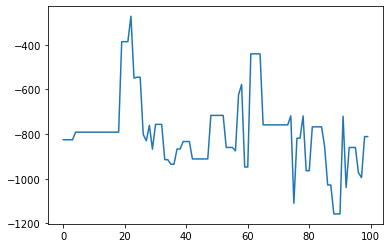

In [5]:
# Inspect MCMC samples -- extract each image for animation, and get scores.
images = []
scores = []
samples = mcmc.get_samples()
for k in range(num_samples):
    data = {key: samples[key][k, ...] for key in samples.keys()}
    images.append(pyro.poutine.condition(sample_keypoint_image, data)(target_im.shape, default_camera_K)[0, :, :])
    scores.append(pyro.poutine.trace(pyro.poutine.condition(conditioned_model, data)).get_trace(target_im).log_prob_sum())
plt.plot(scores)

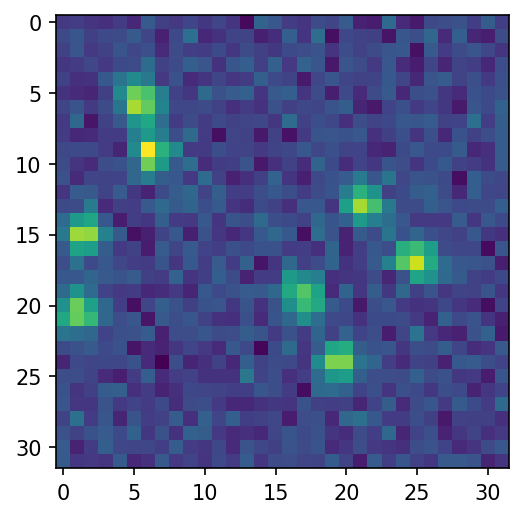

In [6]:
import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

num_frames = min(30, len(images))
step = int(len(images)/num_frames)
sub_images = images[0::step]
def animate(t):
    plt.cla()
    plt.imshow(sub_images[t])
matplotlib.animation.FuncAnimation(fig, animate, frames=len(sub_images))

In [9]:
# Custom written parallel tempered MCMC.
# Wish I could do this within the Pyro API, but the organization of their MCMC doesn't make this easy.

temperatures = np.geomspace(1., prod(target_im.shape)*1000, 5)
chains_per_temperature = 3 # this is implemented using the batching in my model; not general-purpose
num_samples = 200
warmup_steps = int(num_samples/2)
target_im_batched = target_im.unsqueeze(0).repeat((chains_per_temperature, 1, 1))
initial_values = {}

# Prep the kernel for each temperature
kernels = []
samples_by_temp = [] # Strive for same format as MCMC samples
curr_params = []
transforms_by_temp = []
curr_param_scores = torch.empty((len(temperatures), chains_per_temperature))
#initial_values = {key: site["value"].repeat_interleave(chains_per_temperature, dim=0) for key, site in target_trace.nodes.items() if site["type"] is "sample"}
#initial_values["batch"] = torch.range(0, chains_per_temperature-1)
initial_values = {}
for temp in temperatures:
    # TODO: temperature is likely not entering in the theoretically correct way here
    model_kwargs = {"target_ims": target_im.unsqueeze(0).repeat((chains_per_temperature, 1, 1)), "T": temp}
    init_params, potential_fn, transforms, _ = pyro.infer.mcmc.util.initialize_model(
        conditioned_model, model_kwargs=model_kwargs,
        init_strategy=pyro.infer.autoguide.init_to_value(values=initial_values))
    mcmc_kernel = RandomWalkKernel(potential_fn=potential_fn, transforms=transforms, variance=0.1)
    mcmc_kernel.setup(warmup_steps=warmup_steps, kwargs=model_kwargs)
    kernels.append(mcmc_kernel)
    curr_params.append(init_params)
    samples_by_temp.append({key: [value] for key, value in init_params.items()})
    transforms_by_temp.append(transforms)
    

# And grab a potential fn reporting unscaled log probs
model_kwargs = {"target_ims": target_im, "T": 1.}
_, unscaled_potential_fn, _, _ = pyro.infer.mcmc.util.initialize_model(
    conditioned_model, model_kwargs=model_kwargs,
    init_strategy=pyro.infer.autoguide.init_to_value(values=initial_values))

k_boltzmann = 1/4000. # this doesn't have to be the *real* horrible boltzmann constant, does it?

num_swaps_accepted = 0
num_swaps_rejected = 0
for step_k in range(num_samples):
    print("Sample %d/%d" % (step_k, num_samples))
    # Step all of the kernels.
    for temp_k, temp in enumerate(temperatures):
        curr_params[temp_k] = kernels[temp_k].sample(curr_params[temp_k])
        # This involves re-running potential fns, but I hope it isn't that expensive
        # compared to running the full model forward.
        for chain_k in range(chains_per_temperature):
            chain_params = {key: value[chain_k, ...] for key, value in curr_params[temp_k].items()}
            curr_param_scores[temp_k, chain_k] = -unscaled_potential_fn(chain_params)
    # For each temperature, pick a random one-to-one mapping between the chains of the current
    # and higher temperature, and randomly swap those pairs with an MH accept criteria.
    # (Referencing Eq 2.2 of http://www.math.pitt.edu/~cbsg/Materials/Earl_ParallelTempering.pdf)
    for temp_k in range(len(temperatures) - 1):
        permutation = np.random.permutation(chains_per_temperature)
        for lower_chain_k, upper_chain_k in enumerate(permutation):
            lower_log_prob = curr_param_scores[temp_k][lower_chain_k]
            lower_beta = 1./(k_boltzmann*temperatures[temp_k])
            upper_log_prob = curr_param_scores[temp_k+1][upper_chain_k]
            upper_beta = 1./(k_boltzmann*temperatures[temp_k+1])
            accept_prob = torch.exp((-upper_log_prob - (-lower_log_prob))*
                                    (upper_beta - lower_beta))
            accept_prob = torch.clamp(accept_prob, max=1.0)
            #print("Probs %f, %f, betas %f, %f, a %f" % (lower_log_prob, upper_log_prob, lower_beta, upper_beta, accept_prob))
            x = pyro.sample("accept_%d_%d_swap_%d_%d" % (step_k, temp_k, lower_chain_k, upper_chain_k),
                            dist.Uniform(0., 1.))
            if x <= accept_prob:
                print("Accepted: lower energy %f / beta %f, upper energy %f / beta %f" % (lower_log_prob, lower_beta, upper_log_prob, upper_beta))
                num_swaps_accepted += 1
                for key in curr_params[temp_k].keys():
                    temp_param = curr_params[temp_k][key][lower_chain_k, ...].clone()
                    curr_params[temp_k][key][lower_chain_k, ...] = curr_params[temp_k + 1][key][upper_chain_k, ...].clone()
                    curr_params[temp_k + 1][key][upper_chain_k, ...] = temp_param
            else:
                num_swaps_rejected += 1
    # Record resulting samples for this step.
    for temp_k in range(len(temperatures)):
        for key, value in curr_params[temp_k].items():
            samples_by_temp[temp_k][key].append(value.clone())
# Fix up samples: stack them along batch dimension and inverse transform those
# with corresponding transforms.
for temp_k in range(len(temperatures)):
    for key in samples_by_temp[temp_k].keys():
        samples_by_temp[temp_k][key] = torch.stack(samples_by_temp[temp_k][key], dim=0)
    for name, transform in transforms_by_temp[temp_k].items():
        samples_by_temp[temp_k][name] = transform.inv(samples_by_temp[temp_k][name])
print("Accepted %d, Rejected %d = %f percent swaps accepted" % (num_swaps_accepted, num_swaps_rejected, num_swaps_accepted / (num_swaps_accepted + num_swaps_rejected)))

Sample 0/200
Accepted: lower energy -487.510956 / beta 4000.000000, upper energy -196.614594 / beta 125.743343
Accepted: lower energy -415.560516 / beta 4000.000000, upper energy -170.588013 / beta 125.743343
Accepted: lower energy -602.175171 / beta 3.952847, upper energy -390.612122 / beta 0.124261
Accepted: lower energy -486.506073 / beta 3.952847, upper energy -193.963745 / beta 0.124261
Accepted: lower energy -1149.606567 / beta 0.124261, upper energy -321.084778 / beta 0.003906
Accepted: lower energy -390.612122 / beta 0.124261, upper energy -179.722794 / beta 0.003906
Sample 1/200
Accepted: lower energy -415.560516 / beta 125.743343, upper energy -390.612122 / beta 3.952847
Accepted: lower energy -423.459900 / beta 125.743343, upper energy -193.963745 / beta 3.952847
Accepted: lower energy -390.612122 / beta 3.952847, upper energy -321.084778 / beta 0.124261
Accepted: lower energy -193.963745 / beta 3.952847, upper energy -179.722794 / beta 0.124261
Accepted: lower energy -604.3

Accepted: lower energy -184.842163 / beta 125.743343, upper energy -136.434326 / beta 3.952847
Accepted: lower energy -296.233643 / beta 3.952847, upper energy -216.034668 / beta 0.124261
Accepted: lower energy -233.851273 / beta 0.124261, upper energy -221.511398 / beta 0.003906
Sample 55/200
Accepted: lower energy -208.090439 / beta 3.952847, upper energy -197.432190 / beta 0.124261
Sample 56/200
Accepted: lower energy -296.233643 / beta 0.124261, upper energy -233.851273 / beta 0.003906
Sample 57/200
Sample 58/200
Accepted: lower energy -237.338516 / beta 3.952847, upper energy -233.851273 / beta 0.124261
Sample 59/200
Accepted: lower energy -233.851273 / beta 3.952847, upper energy -210.210571 / beta 0.124261
Sample 60/200
Accepted: lower energy -238.956314 / beta 125.743343, upper energy -199.997620 / beta 3.952847
Accepted: lower energy -213.491394 / beta 0.124261, upper energy -149.771210 / beta 0.003906
Sample 61/200
Accepted: lower energy -266.247894 / beta 0.124261, upper ene

Accepted: lower energy -776.089905 / beta 0.124261, upper energy -797.773132 / beta 0.003906
Sample 143/200
Accepted: lower energy -863.146667 / beta 0.124261, upper energy -776.089905 / beta 0.003906
Sample 144/200
Sample 145/200
Accepted: lower energy -121.037796 / beta 125.743343, upper energy -118.697975 / beta 3.952847
Sample 146/200
Sample 147/200
Sample 148/200
Sample 149/200
Sample 150/200
Accepted: lower energy -116.232063 / beta 4000.000000, upper energy -115.279671 / beta 125.743343
Sample 151/200
Sample 152/200
Sample 153/200
Sample 154/200
Sample 155/200
Sample 156/200
Accepted: lower energy -123.121063 / beta 3.952847, upper energy -98.438255 / beta 0.124261
Sample 157/200
Accepted: lower energy -118.411842 / beta 125.743343, upper energy -98.438255 / beta 3.952847
Sample 158/200
Sample 159/200
Accepted: lower energy -114.645485 / beta 4000.000000, upper energy -98.438255 / beta 125.743343
Sample 160/200
Sample 161/200
Sample 162/200
Sample 163/200
Sample 164/200
Accepted

Done with temp  0
Done with temp  1
Done with temp  2
Done with temp  3
Done with temp  4


Text(0.5, 1.0, 'Score -90.259087')

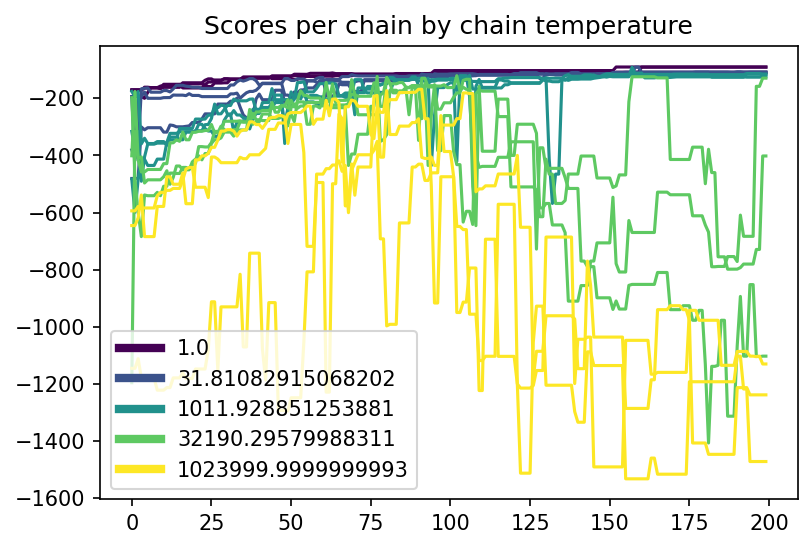

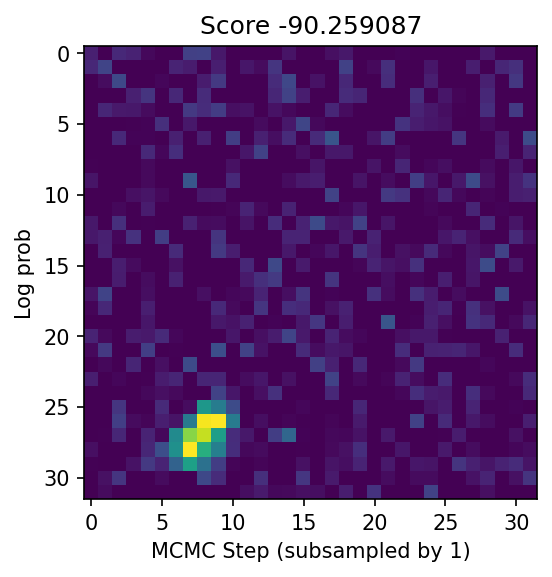

In [10]:
# Inspect resulting samples -- extract each image for animation, and get scores.
from matplotlib.lines import Line2D
images_by_temp = {}
scores_by_temp = {}
best_score = -np.infty
best_im = None
cmap = plt.get_cmap("viridis")
custom_lines = []

subsample_by = 1
for temp_k, (samples, temp) in enumerate(zip(samples_by_temp, temperatures)):
    these_scores = []
    these_images = []
    for chain_k in range(chains_per_temperature):
        images = []
        scores = []
        for k in range(0, num_samples, subsample_by):
            data = {key: samples[key][k, chain_k, ...] for key in samples.keys()}
            images.append(pyro.poutine.condition(sample_keypoint_image, data)(target_im.shape, default_camera_K)[0, :, :].detach().numpy())
            scores.append(pyro.poutine.trace(pyro.poutine.condition(conditioned_model, data)).get_trace(target_im).log_prob_sum().item())
            if scores[-1] >= best_score:
                best_score = scores[-1]
                best_im = images[-1]
        these_images.append(images)
        these_scores.append(scores)
    images_by_temp[temp] = these_images
    scores_by_temp[temp] = np.array(these_scores)
    color = cmap(float(temp_k)/(len(temperatures)-1))
    plt.plot(scores_by_temp[temp].T, c=color)
    custom_lines.append(Line2D([0], [0], color=color, lw=4))
    print("Done with temp ", temp_k)
plt.title("Scores per chain by chain temperature")
plt.legend(custom_lines, temperatures)
plt.figure()
plt.imshow(best_im, vmin=0., vmax=1.)
plt.xlabel("MCMC Step (subsampled by %d)" % subsample_by)
plt.ylabel("Log prob")
plt.title("Score %f" % best_score)